In [5]:
import pandas as pd
import numpy as np
from pydantic import BaseModel, Field, ValidationError, validator
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [77]:
class ProfitLossSimulation(BaseModel):

    S0: float = Field(..., gt=0, description="Initial stock price")
    E: float = Field(..., gt=0, alias="strike", description="Strike price")
    mu: float = Field(..., ge=0, le=1, alias="rate", description="rate")
    sigma_actual: float = Field(..., gt=0, le=1, description="actual Volatility")
    sigma_imp: float = Field(..., gt=0, le=1, description="implied Volatility")
    T: int = Field(..., gt=0, le=3650, alias="dates", description="Days to expiration")
    N_paths: int = Field(..., gt=0, alias="npaths", description="Number of simulations")
    n_steps: int = Field(252, gt=0, alias="timesteps", description="Number of timesteps")
   

    class Config:
        allow_population_by_field_name = True

     
        
    @property
    def pseudorandomnumber(self) -> np.ndarray:
        
        np.random.seed(2025)
        w = np.random.standard_normal((self.n_steps, self.N_paths))
        
        return w

    @property
    def pathsimulation(self) -> np.ndarray:
        
        dt = self.T / self.n_steps

        S = np.zeros((self.n_steps, self.N_paths))
        S[0] = self.S0
        w = self.pseudorandomnumber

        for i in range(0, self.n_steps-1):
           
            S[i+1,:] = S[i,:] * (1 + self.mu*dt + self.sigma_actual*np.sqrt(dt)*w[i,:])
           
        return S

    
    def d_one(self, sigma: float) -> np.ndarray:
         
        S = self.pathsimulation
        dt = self.T / self.n_steps
        

        
        d1 = np.zeros((self.n_steps, self.N_paths))

        for i in range(0, self.n_steps-1):
            
            t = dt * i
            tau = self.T - t
            d1[i,:]= (np.log(S[i,:]/self.E) + (self.mu + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))

           

        return d1

    
    @property
    def deltacalculation(self):


        delta_imp = np.zeros((self.n_steps, self.N_paths))
        delta_actual = np.zeros((self.n_steps, self.N_paths))
        
        d1_imp = self.d_one(self.sigma_imp)
        d1_actual = self.d_one(self.sigma_actual)
     
        delta_imp = norm.cdf(d1_imp)
        delta_actual = norm.cdf(d1_actual)
            

        return delta_imp, delta_actual


    @property
    def gammacalculation(self) -> np.ndarray:
        
        S = self.pathsimulation
        dt = self.T / self.n_steps

        gamma_imp = np.zeros((self.n_steps, self.N_paths))
        d1_imp = self.d_one(self.sigma_imp)

        for i in range(0, self.n_steps-1):
            
            t = dt * i
            tau = self.T - t

            gamma_imp[i,:] = norm.pdf(d1_imp[i,:]) / (self.sigma_imp * S[i,:] * np.sqrt(tau))


        return gamma_imp

    @property
    def profit_loss(self) -> np.ndarray:
        
        dt = self.T / self.n_steps
        
        P_L = np.zeros((self.n_steps, self.N_paths))
        S = self.pathsimulation
            

        delta_imp, delta_actual = self.deltacalculation
      
        gamma_imp = self.gammacalculation
        
        w = self.pseudorandomnumber
        
        for i in range(0, self.n_steps-1):
            
            BM = np.sqrt(dt)* w[i,:]
            
            diffusion_term = 0.5*(self.sigma_actual**2 - self.sigma_imp**2)*(S[i,:]**2)*gamma_imp[i,:]*dt
            
            random_term = +(delta_imp[i,:]-delta_actual[i,:])*self.sigma_actual*S[i,:]*BM
            

            P_L[i+1,:] = P_L[i,:]+ diffusion_term + random_term

        return P_L

    @property
    def optionvalue_BS(self):

        delta_imp, delta_actual = self.deltacalculation
        
        d1_imp = self.d_one(self.sigma_imp)
        d1_actual = self.d_one(self.sigma_actual)

        d2_imp = np.zeros((1, self.N_paths))

        d2_actual = np.zeros((1, self.N_paths))
        
        d2_imp[0,:] = d1_imp[0,:] - self.sigma_imp * np.sqrt(self.T)
        d2_actual[0,:] = d1_actual[0,:] - self.sigma_actual * np.sqrt(self.T)

        value_imp = np.zeros((1, self.N_paths))
        value_actual = np.zeros((1, self.N_paths))
        
        value_imp[0,:] = self.S0 * delta_imp[0,:] - self.E * np.exp(-self.mu * self.T) * norm.cdf(d2_imp[0,:])
        value_actual[0,:] = self.S0 * delta_actual[0,:] - self.E * np.exp(-self.mu * self.T) * norm.cdf(d2_actual[0,:])
        
       
        PL_BS = (value_actual[0,:]-value_imp[0,:]).mean()
        
        return PL_BS        

In [79]:
simulation01 = ProfitLossSimulation(
                            S0=100, 
                            strike=100, 
                            rate=0.05, 
                            sigma_actual=0.3,
                            sigma_imp=0.2, 
                            dates=1, 
                            npaths=100000, 
                            n_steps=252
                )


In [62]:
PandL = simulation01.profit_loss

In [64]:
PandL[-1,:].mean()

3.8577294305214482

In [66]:
PandL[-1,:].std()

0.2515301515573105

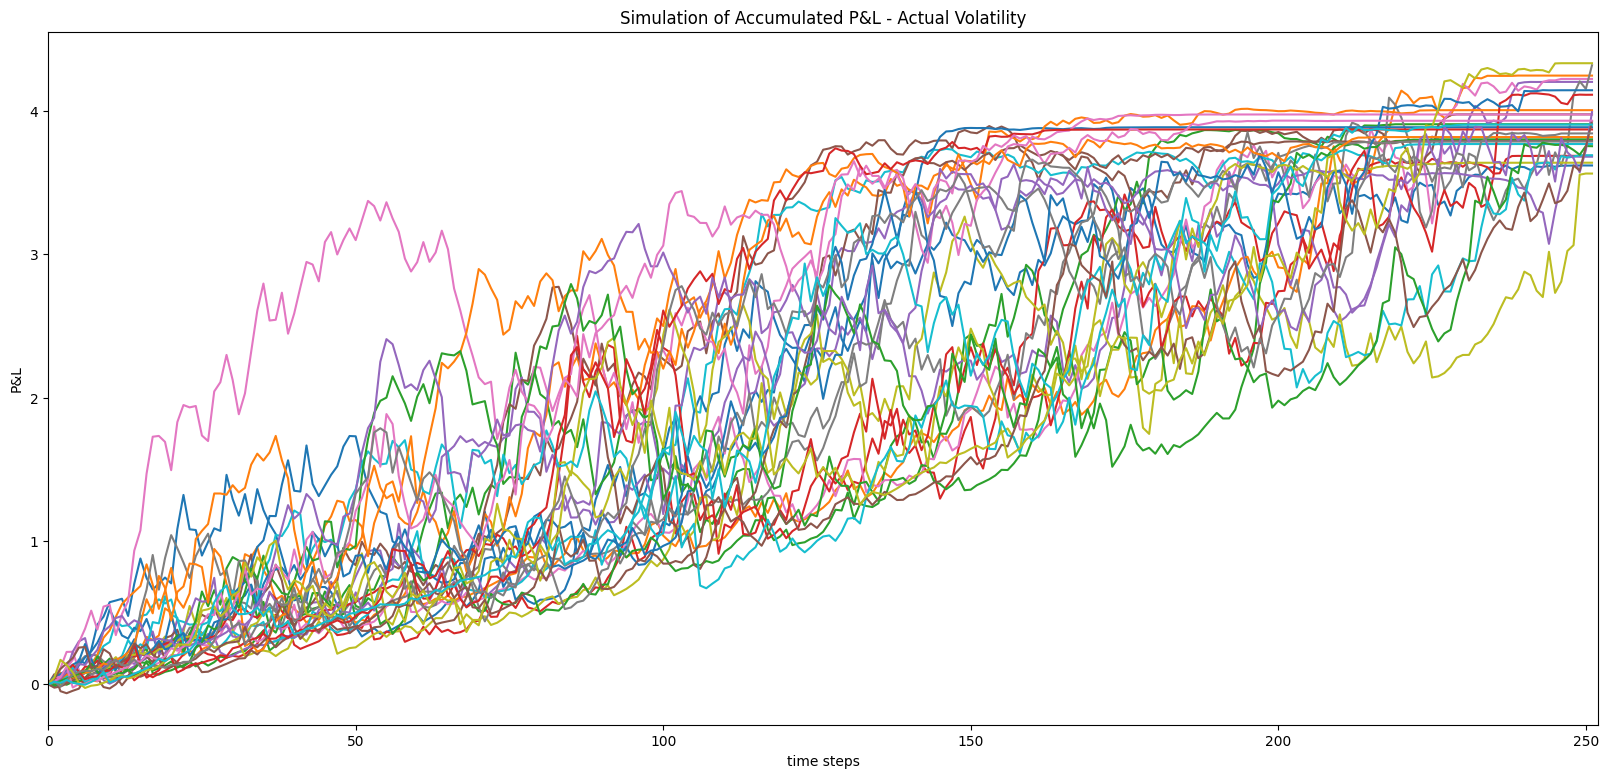

In [75]:
plt.figure(figsize=(20,9))
plt.plot(simulation01.profit_loss[:,:30])
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('P&L')
plt.title('Simulation of Accumulated P&L - Actual Volatility');

(array([3.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 2.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 8.000e+00, 7.000e+00, 1.000e+01,
        1.100e+01, 8.000e+00, 1.900e+01, 2.300e+01, 2.600e+01, 3.100e+01,
        4.300e+01, 4.600e+01, 5.300e+01, 7.800e+01, 8.100e+01, 1.120e+02,
        1.270e+02, 1.620e+02, 2.180e+02, 2.660e+02, 2.650e+02, 3.620e+02,
        4.240e+02, 5.330e+02, 5.840e+02, 7.740e+02, 8.860e+02, 1.190e+03,
        1.343e+03, 1.742e+03, 2.198e+03, 2.678e+03, 3.192e+03, 4.036e+03,
        4.650e+03, 5.395e+03, 6.183e+03, 6.565e+03, 6.856e+03, 6.691e+03,
        6.529e+03, 5.830e+03, 5.056e+03, 4.460e+03, 3.749e+03, 3.139e+03,
        2.609e+03, 2.152e+03, 1.805e+03, 1.407e+03, 1.085e+03, 9.780e+02,
        7.900e+02, 5.600e+02, 4.450e+02, 3.520e+02, 2.570e+02, 2.080e+02,
        1.620e+02, 1.400e+02, 1.070e+02, 7.500e+01, 5.900e+01, 4.100e+01,
        2.300e+01, 2.200e+01, 1.900e+01, 1.300e+01, 7.000e+00, 7.000e+00,
        6.000e+00, 1.000e+00, 4.000e+0

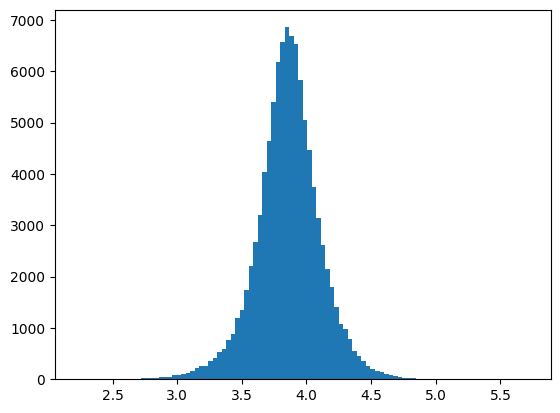

In [60]:
plt.hist(simulation01.profit_loss[-1], bins=100)

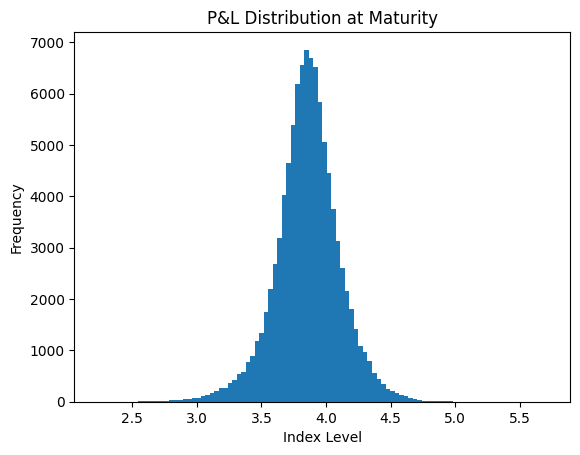

In [73]:
plt.hist(PandL[-1,:].flatten(), bins=100)
plt.title('P&L Distribution at Maturity')
plt.xlabel('Index Level')
plt.ylabel('Frequency')
plt.show()

In [68]:
PandL[-1,:].mean(), PandL[-1,:].std()

(3.8577294305214482, 0.2515301515573105)

In [81]:
PL_BS = simulation01.optionvalue_BS

In [83]:
print(PL_BS)

3.780671213800254


In [85]:
distance = PL_BS - PandL[-1,:].mean()

In [87]:
print(distance)

-0.0770582167211944
